### **Лекция 1. Intro to Machine Learning**

В датасете мы хотим две вещи: чтобы строки(наблюдения) независимы, и чтобы они были одинаково распределены

Независимы - в датасете нет двух одинаковых строк Джон - Джон

Одинаково распределены - наблюдения имеют одинаковую природу

В самом датасете та его часть, которая не включает целевые фичи называется **design matrix**:

![design_matrix](/Users/dadaya/Desktop/progs/design_matrix.png)

Определим нашу **задачу**(Задачу машинного обучения с учителем(с заданным таргетом)):

Обозначим:

$\cdot$ Тренировочный датасет $\mathcal{L}$ = $\{\textbf{X}_i; y_i\}^n_{i = 1}$

Для регрессии: ($\textbf{X} \in \mathcal{R}^p, y \in \mathcal{R} $)

Для бинарной классификации: $\textbf{X}_i \in \mathcal{R}^p,y \in \{+1, -1\}$

$\cdot$ Модель $f(\textbf{X}): \textbf{X} \rightarrow y$ предсказывает какое-то значение(y) для каждого наблюдения

$\cdot$ Функция потери $\mathcal{Q}(\textbf{X}, y, f)$, которую нужно минимизировать

##### **Наивный Баессовский классификатор**

Обозначим:

$\cdot$ Тренировочный датасет $\mathcal{L}$ = $\{\textbf{X}_i; y_i\}^n_{i = 1}$

Для k-классового определения: $\textbf{X}_i \in \mathcal{R}^p,y \in \{C_1,..., C_k\}$

Вспомним теорему Байеса:
$$P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}$$

И попробуем применить ее к нашей выборке:
$$P(y_i = C_k|\textbf{X}_i) = \frac{P(\textbf{X}_i|y_i = C_k) \cdot P(y_i = C_k)}{P(\textbf{X}_i)}$$

Наивное предположение(фичи независимы):
$$P(\textbf{X}_i|y_i = C_k) = \prod^p_{l = 1} P(x^l_i|y_i = C_k)$$

Оптимальный класс:
$$C^* = arg \max_kP(y_i = C_k)$$

##### **kNN - метод k ближайших соседей**

![kNN](/Users/dadaya/Desktop/progs/kNN.png)

Чтобы определить цвет новой точки, нужно:
1. Посчитать расстояние до каждой точки из датасета
2. Выбрать точки из датасета с минимальным расстоянием до них
3. Цвет точки будет самым часто встречающимся среди этих ближайших соседей

Тут мы встречаемся с понятием **гиперпараметра** - того параметра, который мы не можем заранее предсказать, нам нужно сначала его выбрать, а только затем анализировать, какое из его значений лучше всего подходит, в данном случае это - количество ближайших соседей:

![kNN_2](/Users/dadaya/Desktop/progs/kNN_2.png)

А теперь к первому семинару!

### **Семинар 1. Наивный Баейс**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [2]:
dataset = datasets.load_iris()

ext_target = dataset.target[:, None]
# ext_target = np.expand_dims(dataset.target, axis=-1)
df = pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=dataset.feature_names + ['target label', 'target name'],
)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target label,target name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [3]:
dataset = datasets.load_iris()
features = dataset.data
target = dataset.target

features.shape, target.shape

((150, 4), (150,))

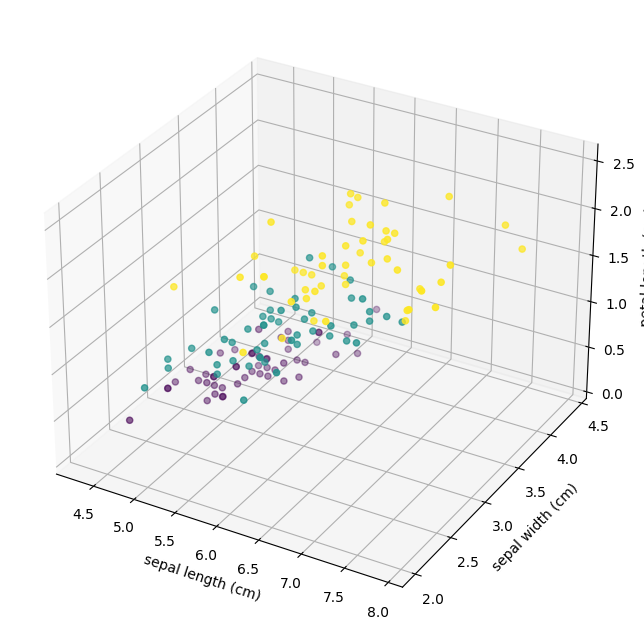

In [4]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection = '3d')

ax.scatter(features[:, 0], features[:, 1], features[:, 3], c=target, marker='o')
ax.set_xlabel(dataset.feature_names[0])
ax.set_ylabel(dataset.feature_names[1])
ax.set_zlabel(dataset.feature_names[2])

plt.show()

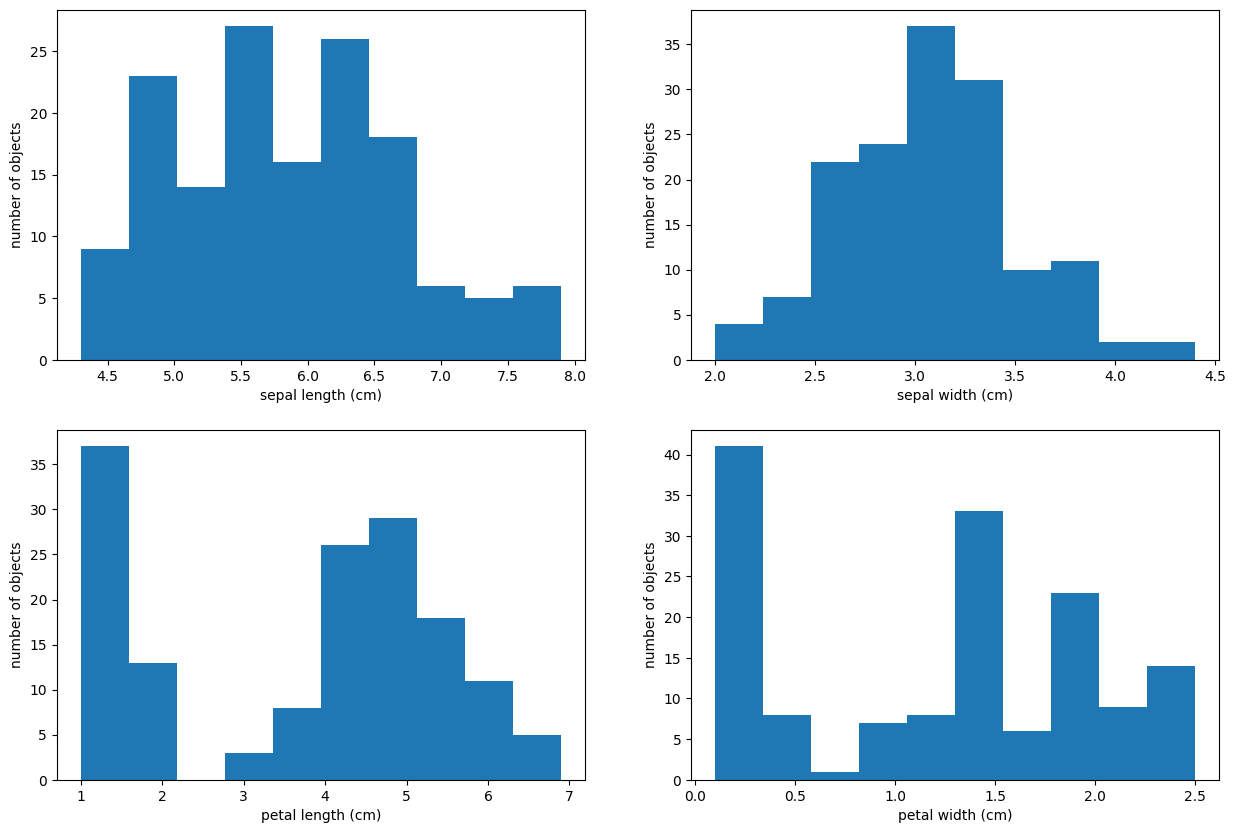

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, axis in enumerate(axes.flat):
    axis.hist(features[:, i])
    axis.set_xlabel(dataset.feature_names[i])
    axis.set_ylabel('number of objects')

## Реализация классификатора

Т.к. мы стремимся реализовать алгоритм Наивного Байеса, сперва нам нужно определить приорное распределение.

Самое классическое распределение, разумеется, Гауссовское, и его параметры - среднее и стандартное отклонение. Давайте реализуем класс, которому подается на вход список значений фич, который оценивает распределение параметров и на его основе дает плотность вероятности поданной фичи.

В базовом предположении наши данные идут из нормального распределения, если не сказано обратного. Здесь же, явно видно, что первые два можно свести к нормальному(они имеют одну моду), а третье и четвертое - нет(они мультимодальны)

Поэтому нам лучше использовать некую эмпирическую функцию распределения, которая просто будет соответствовать гистограмме, но идти более плавно, более красиво - kdeplot

Обозначим плотность нормального распределения $\mathcal{N}(\mu, \sigma^2)$:
$$
f(x|\mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x - \mu)^2}{2\sigma^2})
$$

In [6]:
class GaussianDistribution:
    def __init__(self, feature):
        '''
        Args:
            feature: column of design matrix, represents all available values
                of feature to model.
                axis=0 stays for samples.
        '''
        self.mean = feature.mean(axis=0)
        self.std = feature.std(axis=0)

    def logpdf(self, value):
        '''Logarithm of probability density  at value'''
        return -0.5 * np.log(2. * np.pi * self.std ** 2) - (value - self.mean)**2 / (2 * self.std**2)
    
    def pdf(self, value):
        return np.exp(self.logpdf(value))

Проверим результаты:

In [7]:
import scipy
_test = scipy.stats.norm(loc=features[:, :2].mean(axis=0), scale=features[:, :2].std(axis=0))
assert np.allclose(
    GaussianDistribution(features[:, :2]).logpdf(features[:5, :2]),
    _test.logpdf(features[:5, :2])
)
print('Все хорошо!')

Все хорошо!


Давайте сфокусируемся на проблеме классификации. Для случая K классов ярлык $y_i \in \{C_1, \ldots, C_k\}$. Наш датасет ирисов имеет триадную классификацию, то есть K = 3. Теорема Байеса имеет следующую форму:

$$
P(y_i = C_k|\mathbf{x}_i) = \frac{P(\mathbf{x}_i|y_i = C_k) P(y_i = C_k)}{P(\mathbf{x}_i)}
$$

Отметим, что мы предпочитаем работать с логарифмами. Тогда предыдущее выражение принимает вид:
$$
\log P(y_i = C_k|\mathbf{x}_i) = \log P(\mathbf{x}_i|y_i = C_k) + \log P(y_i = C_k) - \log P(\mathbf{x}_i)
$$

Как мы уже отмечали выше, для того, чтобы найти ярлык класса с наибольшей вероятностью, нам даже не нужен последний член $P(\mathbf{x}_i)$. Но, нам он нужен для корректной оценки вероятности $P(y_i = C_k|\mathbf{x}_i)$. Член $P(\mathbf{x}_i)$ может быть вычислен по следующему свойству:
$$
P(\mathbf{x}_i) = \sum_{k=1}^K P(\mathbf{x}_i|y_i=C_k).
$$
Он может быть вычислен из значений $\log P(\mathbf{x}_i|y_i=C_k)$, используя функцию `logsumexp` из `scipy.special`.

Сейчас же давайте реализуем Наивный Байессовский классификатор. Класс ниже наследует методы базовых классов `sklearn`

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp


class NaiveBayes(BaseEstimator, ClassifierMixin):
    '''
    Please note, using `X` and `y` for design matrix and labels in general is not a good choice,
    better stick to more informative naming conventions.
    However, to make the code consistent with sklearn implementation, we use `X` and `y` variables here.
    # '''
    def fit(self, X, y, sample_weight=None, distributions=None):
        '''
        sample_weight 
            The argument is ignored. For comatibility only.
        '''
        self.unique_labels = np.unique(y)
        
        # If distributions of features are not specified, they a treated Gaussian
        if distributions is None:
            distributions = [GaussianDistribution] * X.shape[1]
        else:
            # Check whether distributions are passed for all features
            assert len(distributions) == X.shape[1]

        # Here we find distribution parameters for every feature in every class subset
        # so P(x^i|y=C_k) will be estimated only using information from i-th feature of C_k class values
        self.conditional_feature_distributions = {} # label: [distibution for feature 1, ...]
        for label in self.unique_labels:
            feature_distribution = []
            for column_index in range(X.shape[1]):
                # `column_index` feature values for objects from `label` class
                feature_column = X[y == label, column_index]
                fitted_distr = distributions[column_index](feature_column)
                feature_distribution.append(fitted_distr)
            self.conditional_feature_distributions[label] = feature_distribution

        # Prior label distributions (unconditional probability of each class)
        self.prior_label_distibution = {
            label: sum((y==label).astype(float)) / len(y)
            for label in self.unique_labels
        }

    
    def predict_log_proba(self, X):
        # Matrix of shape (n_objects : n_classes)
        class_log_probas = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)
        
        # Here we compute the class log probabilities for each class sequentially b
        for label_idx, label in enumerate(self.unique_labels):
            for idx in range(X.shape[1]):
                # All loglikelihood for every feature w.r.t. fixed label

                class_log_probas[:, label_idx] += self.conditional_feature_distributions[label][idx].logpdf(X[:, idx])

            # Add log proba of label prior
            class_log_probas[:, label_idx] += np.log(self.prior_label_distibution[label])

        for idx in range(X.shape[1]):
        # If you want to get probabilities, you need to substract the log proba for every feature
            class_log_probas -= logsumexp(class_log_probas, axis=1)[:, None]
        return class_log_probas
    
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    
    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        # we need to cast labels to their original form (they may start from number other than 0)
        return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])

In [9]:
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25)

nb = NaiveBayes()
nb.fit(features_train, target_train, distributions=[GaussianDistribution]*4)
nb_test_log_proba = nb.predict_log_proba(features_test)

sklearn_nb = naive_bayes.GaussianNB()
sklearn_nb.fit(features_train, target_train)
sklearn_nb_test_log_proba = sklearn_nb.predict_log_proba(features_test)

In [10]:
assert np.allclose(nb_test_log_proba, sklearn_nb_test_log_proba), 'log probabilities do not match'
print('Все хорошо!')

Все хорошо!


#### Сравнение с kNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
knn = KNeighborsClassifier(n_neighbors=2)

In [13]:
knn.fit(features_train, target_train)

KNeighborsClassifier(n_neighbors=2)

In [14]:
knn.score(features_train, target_train)

0.9732142857142857

In [15]:
knn.score(features_test, target_test)

0.9736842105263158

Похоже на то, что Наивный Байесовский классификатор сравним с kNN, при том, что первому не нужно хранить всю тренировочную дату.

## Улучшенное распределение для Наивного Байеса

Давайте посмотрим на скрипичные диаграммы(violin plot) для каждой фичи нашего датасета:

{'bodies': [<matplotlib.collections.PolyCollection at 0x1732f0d90>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1732c5750>,
 'cmins': <matplotlib.collections.LineCollection at 0x173e80550>,
 'cbars': <matplotlib.collections.LineCollection at 0x173e81cd0>,
 'cmedians': <matplotlib.collections.LineCollection at 0x173e80250>}

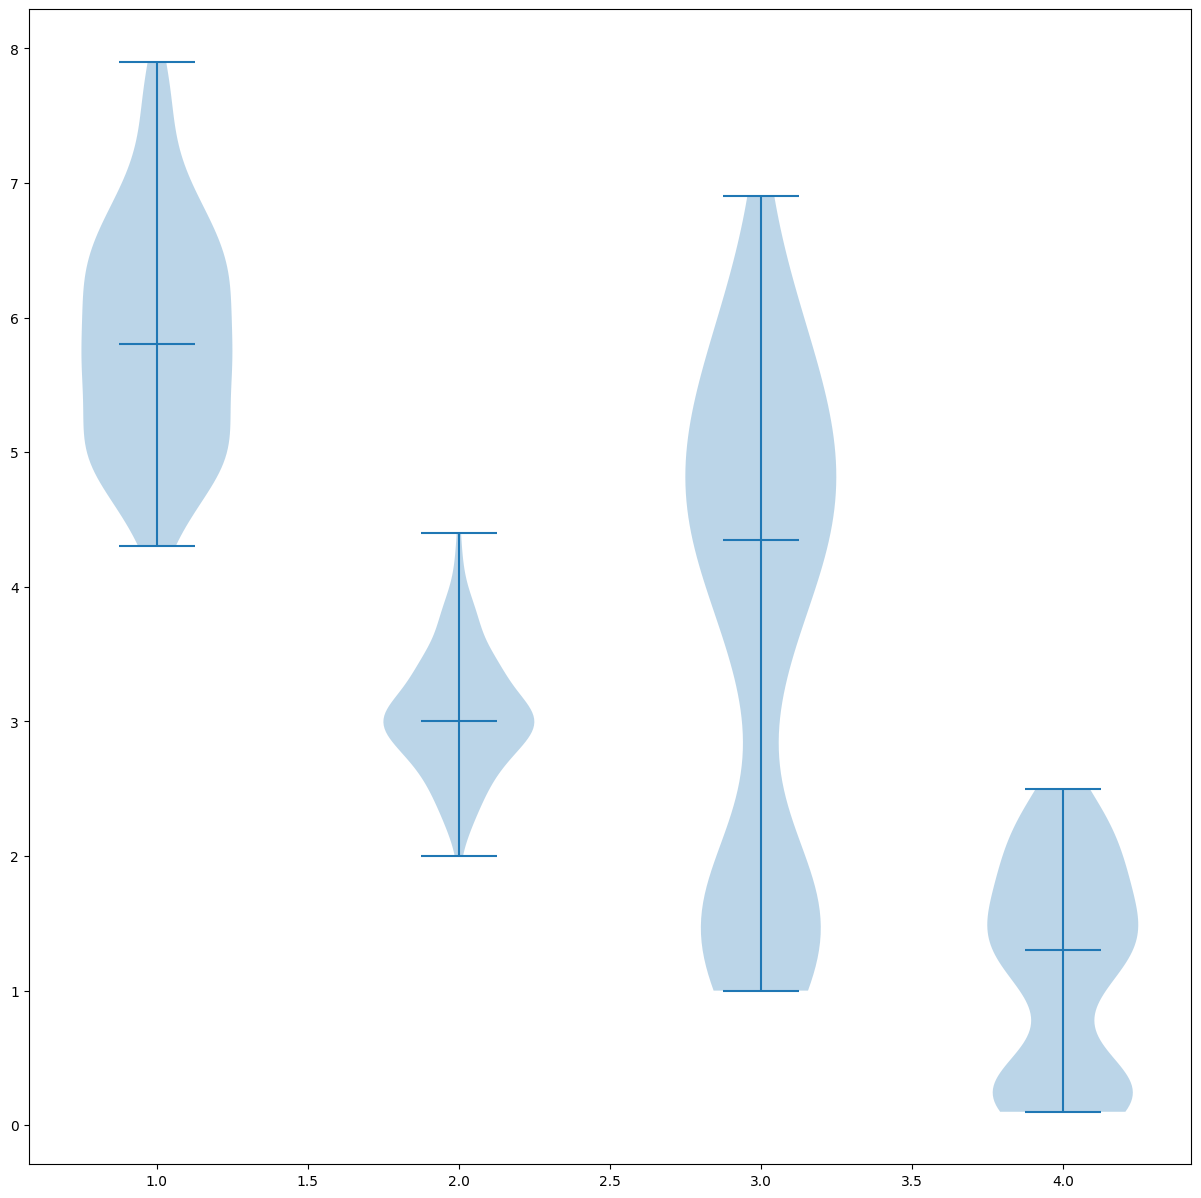

In [16]:
plt.figure(figsize=(15, 15))
plt.violinplot(features, showmedians=True)

Несмотря на то, что мы любим Гауссовское распределение, оно все еще мономодально, хотя наши фичи характерно мультимодальны(посмотрите на гистограммы выше). Значит, нам нужно реализовать более крепкую оценочную функцию распределения - Kernel Density Estimator (KDE).

Идея этого метода проста: мы назначаем какую-то плотность вероятности области вокруг реального наблюдения(Мы еще вернемся к DE методам, опишем их более аккуратно позже)

К счастью, у `sklearn` уже есть встроенный KDE. Все, что ему требуется - вектор фич.

Чтобы получить оценку вероятности с помощью KDE, нужно всего лишь достать ее из `sklearn.neighbors`

Text(0, 0.5, 'probability')

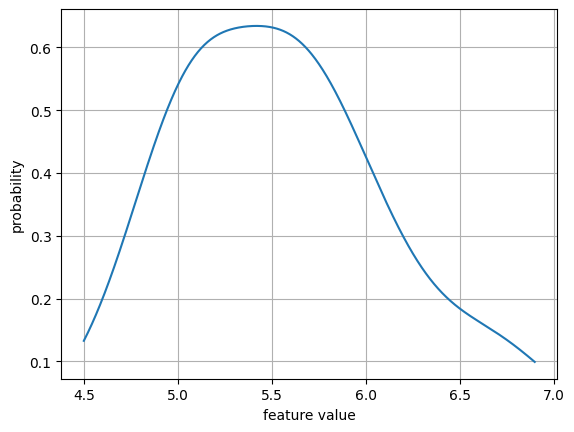

In [17]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.28, kernel='gaussian')
feature_col = features[target==2, 2]
kde.fit(feature_col.reshape((-1, 1)))
linspace = np.linspace(feature_col.min(), feature_col.max(), 1000)
plt.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))))
plt.grid()
plt.xlabel('feature value')
plt.ylabel('probability')

Чтобы сделать ее сравнимой с Наивным Байессовским классификатором, который мы реализовали выше, нам нужно создать класс с такими же методами:

In [18]:
class GaussianKDE:
    def __init__(self, feature):
        self.kde = KernelDensity(bandwidth=1.)
        self.kde.fit(feature.reshape((-1, 1)))

    def logpdf(self, value):
        return self.kde.score_samples(value.reshape((-1, 1)))

    def pdf(self, value):
        return np.exp(self.log_proba(value))

In [19]:
nb_kde = NaiveBayes()
nb_kde.fit(features, target, distributions=[GaussianKDE]*4)
print('log probas:\n{}'.format(nb_kde.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb_kde.predict(features[:2])))
print('\nОно живое!')

log probas:
[[-0.01065833 -4.55225418 -9.74947306]
 [-0.01233815 -4.4058583  -9.77739583]]
predicted labels:
[0 0]

Оно живое!


In [20]:
print('KDE Naive Bayes classifier accuracy on the train set: {}'.format(nb_kde.score(features_train, target_train)))

KDE Naive Bayes classifier accuracy on the train set: 0.9375


In [21]:
print('KDE Naive Bayes classifier accuracy on the test set: {}'.format(nb_kde.score(features_test, target_test)))

KDE Naive Bayes classifier accuracy on the test set: 0.9210526315789473


Похоже на то, что точность классификатора упала, что происходит?

Подсказка: попробуем изменить параметр `bandwidth` из `KernelDensity` конструктора в классе `GaussianKDE`(на примерно 0.3)

Давайте взглянем поближе на распределение фич. Получим гистограммы:

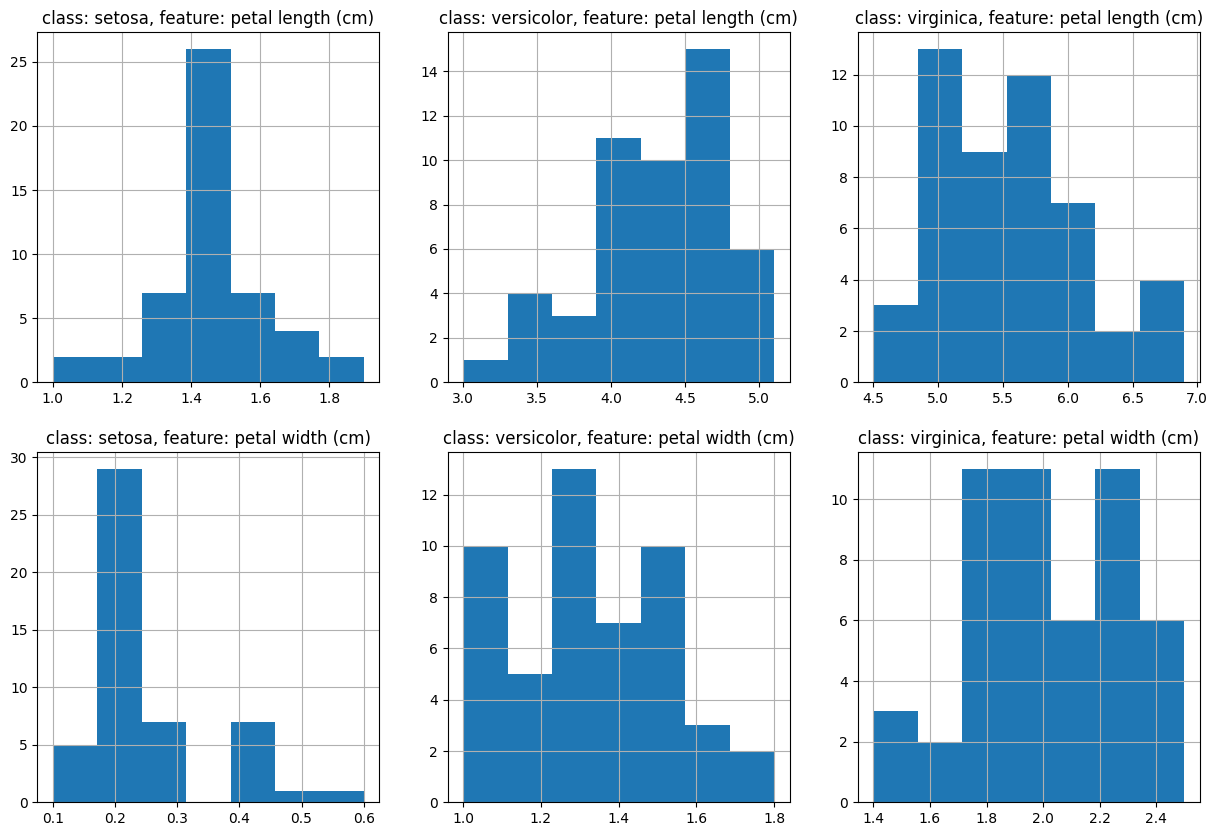

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        ax.hist(feature_col, bins=7)
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

Видим, что распределения в пределах каждого класса мономодальны. Вот как KDE аппроксимирует PDF:

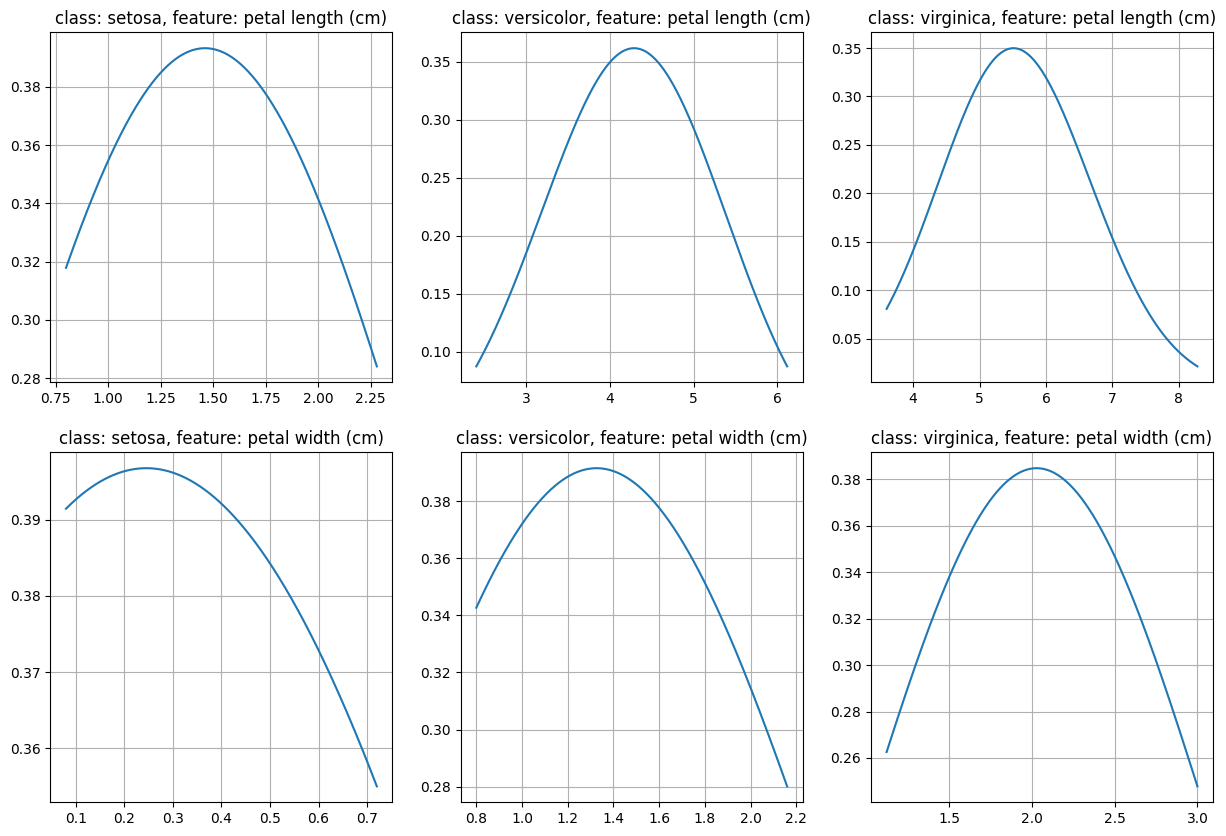

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
kde = KernelDensity(bandwidth=1., kernel='gaussian')

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        kde.fit(feature_col.reshape((-1, 1)))
        linspace = np.linspace(
            0.8*feature_col.min(),
            1.2*feature_col.max(),
            1000
        )
        ax.plot(linspace, np.exp(kde.score_samples(linspace.reshape((-1, 1)))))
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

Кто-то скажет, что каждой фиче нужно свое значение `bandwidth`.

И вот как Гауссово распределение фиттит дату:

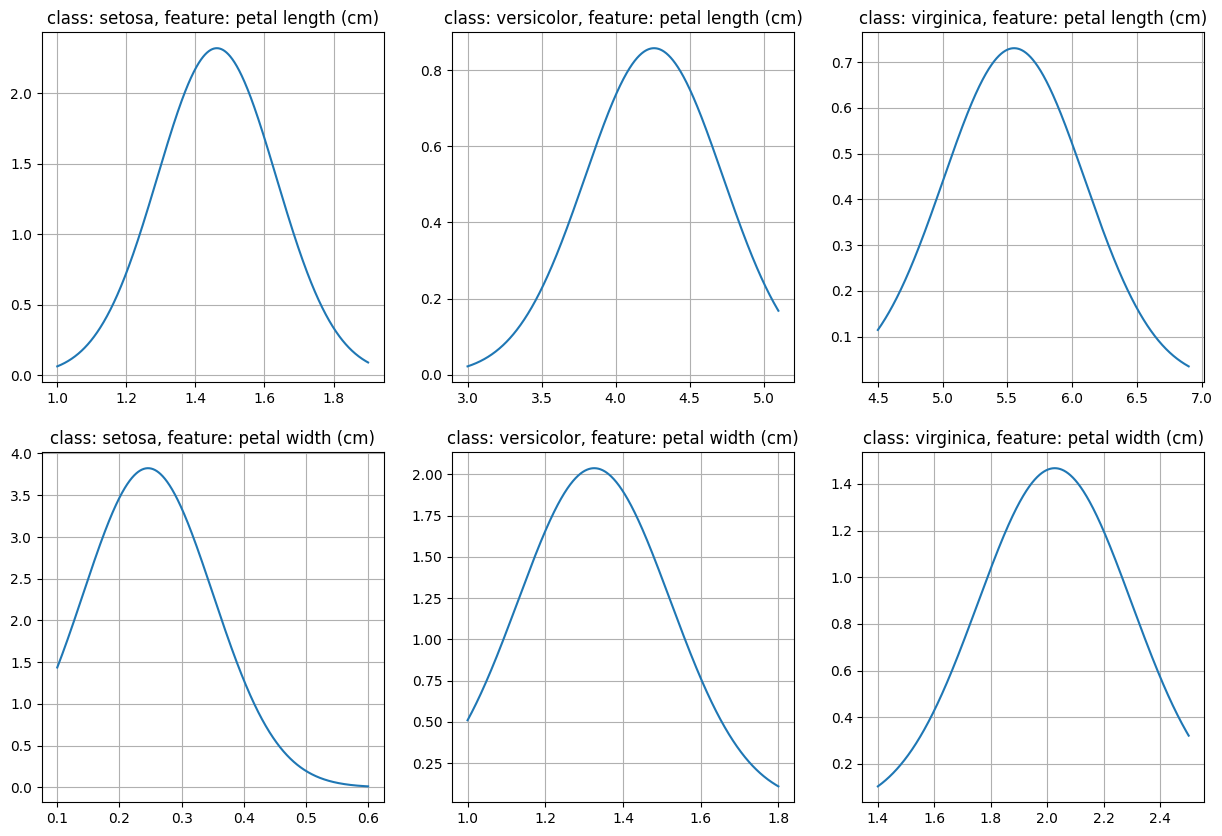

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax_idx, feature_idx in enumerate([2, 3]):
    for label in range(3):
        ax = axes[ax_idx, label]
        feature_col = features[target==label, feature_idx]
        gaussian_distr = GaussianDistribution(feature_col)
        linspace = np.linspace(
            feature_col.min(),
            feature_col.max(),
            1000
        )
        ax.plot(linspace, gaussian_distr.pdf(linspace.reshape((-1, 1))))
        ax.grid()
        ax.set_title('class: {}, feature: {}'.format(
            dataset.target_names[label],
            dataset.feature_names[feature_idx]
        ))

Выглядит получше. К тому же, теперь гипотеза о нормальном распределении у фич выглядит более убедитильно(т.к. в фичах - длина и ширина цветка)

### **Лекция 2. Линейные модели. Линейная регрессия**
##### Задача линейной регрессии
$\cdot$ Датасет $\mathcal{L} = \{\textbf{X}_i, y_i\}^N_{i = 1}$, где $\textbf{X}_i \in \mathcal{R}^n, y_i \in \mathcal{R}$

$\cdot$ $\widehat{y} = \omega _0 + \sum_{k = 1}^p x_k \cdot \omega_k = //\textbf{X} = [1, x_1, x_2, ..., x_p]// = \textbf{X}^T \Omega$, где $\Omega = (\omega _0, \omega _1,..., \omega _n)$ - наш вектор весов

$\cdot$ Метод наименьших квадратов дает решение:
$$\widehat{\Omega} = arg \min_{\Omega} ||Y - \widehat{Y}||^2_2 = arg \min_{\Omega} ||Y - X\Omega||^2_2$$
Это - среднеквадратическая ошибка, или функция эмпирического риска - Функция ошибки - $\mathcal{Q}(\Omega)$

##### __Теорема Гаусса-Маркова__
Предположим, что целевые значения выражены следующей формулой, где $\varepsilon = [\varepsilon _1,..., \varepsilon _N]$ - случайные переменные - шумы:
$$Y = X\Omega + \varepsilon$$
И:

$\cdot$ $E(\varepsilon _i) = 0$ $\forall i$

$\cdot$ $D(\varepsilon _i) = \sigma ^2 < inf$ $\forall i$

$\cdot$ $Cov(\varepsilon _i, \varepsilon _j) = 0$ $\forall i \neq j$

Тогда:
$$\widehat{\Omega} = (X^TX)^{-1}X^TY$$
- оптимальное решение(**B**est **L**inear **U**nbaised **E**stimator - BLUE)

Различные функции потери задачи регрессии:

Mean Square Error - **MSE**($\textbf{y}$, $\widehat{\textbf{y}}$) = $\frac{1}{N}||\textbf{y} -\widehat{\textbf{y}}||^2_2 = \frac{1}{N}\sum_i(y_i - \widehat{y}_i)^2$
- Дает BLUE согласно теореме Гаусса-Маркова - что значит может использоваться только если выполнены ее условия
- Дифференцируема
- НО чувствительна к шуму(он возводится во вторую степень)

Mean Absolute Error - **MAE**($\textbf{y}$, $\widehat{\textbf{y}}$) = $\frac{1}{N}||\textbf{y} -\widehat{\textbf{y}}||_1 = \frac{1}{N}\sum_i|y_i - \widehat{y}_i|$
- не дифференцируема, но это не проблема
- намного более терпима к шуму
Сравнение $L_1$ и $L_2$ регрессии:
![MSE/MAE](/Users/dadaya/Desktop/progs/MSE_MAE.png)

Модели имеют свойство обучаться, и по ходу их обучения возникает три этапа, недообучение, идеальное обучение и переобучение:
![under_over_fitting_2](/Users/dadaya/Desktop/progs/under_over_fitting_2.png)
![under_over_fitting](/Users/dadaya/Desktop/progs/under_over_fitting.png)

Получив данные, мы делим их на тренировочную(ту, на которой модель обучается), и валидационную(и ту, на которой модель проверяется) дату. Финальная же проверка обучно производится на тестовой дате, доступа к которой мы зачастую не имеем. Поэтому, например, модель, переобучившись на валидационную дату, может дать на ней прекрасные результаты с минимальной ошибкой, а на тестовой выступить отвратительно.
![Training_validation_testing](/Users/dadaya/Desktop/progs/Training_validation_testing.png)

А теперь ко второму семинару!
### Семинар 2. Линейная регрессия. Стохастический градиентный спуск

In [25]:
import matplotlib
import warnings
warnings.filterwarnings("ignore")

random_seed = 42

matplotlib.rcParams.update({'font.size': 16})

In [26]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43
np.random.seed(random_seed)

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features)) # сами создали матрицу X

# For different scales of features. In case of 3 features the code is equal to the commented line below
# X *= np.arange([1, 3, 5])[None, :]
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects) # перенормировали матрицу X и получили матрицу Y

*Recap:*
В случае линейной модели:
$$
\hat{Y} = X\mathbf{w}
$$
и функция потери - __MSE__:
$$
Q(Y, X, \mathbf{w}) = MSE(Y, X\mathbf{w}) =  \|Y - X\mathbf{w}\|^2_2 = \sum_i (y_i - \mathbf{x}^T_i \mathbf{w})^2
$$
аналитическое решение имеет простой вид:

$$
\mathbf{w}^* = (X^T X)^{-1}X^T Y.
$$

Давайте посмотрим, как это работает:

In [27]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [28]:
w_star

array([ 0.47972294, -0.14120539])

In [29]:
w_true

array([ 0.49671415, -0.1382643 ])

Как мы видим, аналитическое решение очень близко к оригинальному.
Теперь давайте сгенерируем датасет с взаимно зависимыми фичами:

In [30]:
n_features = 3
n_objects = 300
batch_size = 10
num_steps = 43
eps = 1e-3

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# Now we duplicate the second feature with some small noise, so featues 2 and 3 are collinear
X[:, -1] = X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape)

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))

In [31]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
w_star

array([  0.48700793, -69.07536975,  68.40343133])

In [32]:
w_true

array([ 0.4933179 ,  0.18483612, -0.85835778])

In [33]:
w_star[1:].sum()

-0.6719384207152501

In [34]:
w_true[1:].sum()

-0.6735216564863397

Как мы видим второй и третий коэффиценты противоположны. Это делает нашу модель сильно *нестабильной*.
Как мы можем это исправить? Тут на помощь приходит __регуляризация__.

Давайте используем $L_2$ норму весовых векторов как регуляризацию для ограничения желанного решения.

$$
Q_{\text{reg}}(Y, X, \mathbf{w}) = MSE(Y, X\mathbf{w}) + \lambda\|\mathbf{w}\|_2^2=  \|Y - X\mathbf{w}\|^2_2 + \lambda\|\mathbf{w}\|^2_2= \sum_i (y_i - \mathbf{x}^T_i \mathbf{w})^2 + \sum_p w^2_p
$$

Аналитическое решение тоже доступно в этом случае:

$$
\mathbf{w}^*_{\text{reg}} = (X^T X + \lambda I_p)^{-1}X^T Y,
$$
, где $I_p$ - это единичная матрица порядка p

__Нужно быть осторожным с регуляризацией, если мы включили колонку единиц в матрицу X! Мы не хотим регуляризовать Байеса в нашей линейной модели__

In [35]:
w_star_reg = np.linalg.inv(X.T.dot(X) + 0.05*np.eye(n_features)).dot(X.T).dot(Y)
w_star_reg # получили устойчивое решение

array([ 0.48613994, -0.40147871, -0.27069967])

In [36]:
w_true[1:].sum()

-0.6735216564863397

In [37]:
w_star_reg[1:].sum()

-0.6721783832860171

### Градиентный спуск
Аналитическое решение, описанное выше, включает в себя инвертирование матрицы $X^T X$ (or $X^T X + \lambda I$), которое довольно затратно с точки зрения ресурсов компьютера. Сложность инвертирования матрицы может быть оценена как $O(p^3 + p^2 N)$. Это приводит нас к итерационным методам оптимизации, которые наиболее эффективны и, де-факто, являются главным подходом к оптимизации в машинном обучении.

Градиентный спуск - один из самых популярных методов оптимизации. Стоит упомянуть факт того, что минимизация(максимизация) цели(функции потери) должна быть дифференцируемой, отсылаясь к параметрам модели. Используя градиентный спуск, вектор весов $\mathbf{w}^{(t+1)}$ на $t + 1$ шагу может быть записан в виде:
$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta_t \nabla Q(\mathbf{w}^{(t)}),
$$
, где $\eta_t$ означает шаг градиента(обычно обозначается как _learning rate_)

Градиент в случае функции потери MSE принимает следующую форму:
$$
\nabla Q(\mathbf{w}) = -2X^TY + 2X^TX\mathbf{w} = 2X^T(X\mathbf{w} - Y).
$$

В этом случае сложность всего лишь $O(pN)$. Чтобы сделать его еще более эффективным(и используя гипотезу связанных данных в датасете) мы можем использовать _стохастический градиентный спуск_, который считает градиент только среди какой-то случайной части даты K раз, из-за чего сложность снижается до $O(pK)$, где $K << N$.

### Визуализируем траекторию градиентного спуска
Давайте поближе взглянем на путь оптимизации в простом двумерном пространстве(где фичи в различных размерностях). Мы будем использовать функцию потери MSE.

Графики ниже показывают значения $\mathbf{w}^{(t)}$ на каждом шагу $t$. Красная точка в центре обозначает $\mathbf{w}_{\text{true}}$.

In [38]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43
np.random.seed(random_seed)

# Let it be the *true* weights vector
w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))

# For different scales of features. In case of 3 features the code is equal to the commented line below
# X *= np.arange([1, 3, 5])[None, :]
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :] 

# Here comes the *true* target vector
Y = X.dot(w_true) + np.random.normal(0, 1, n_objects)

In [39]:
np.random.seed(random_seed)
w_0 = np.random.uniform(-2, 2, n_features)-0.5
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-2

for i in range(num_steps):
    w -= step_size * 2. * np.dot(X.T, (X.dot(w) - Y)) / Y.size # YOUR CODE HERE
    w_list.append(w.copy())
w_list = np.array(w_list)

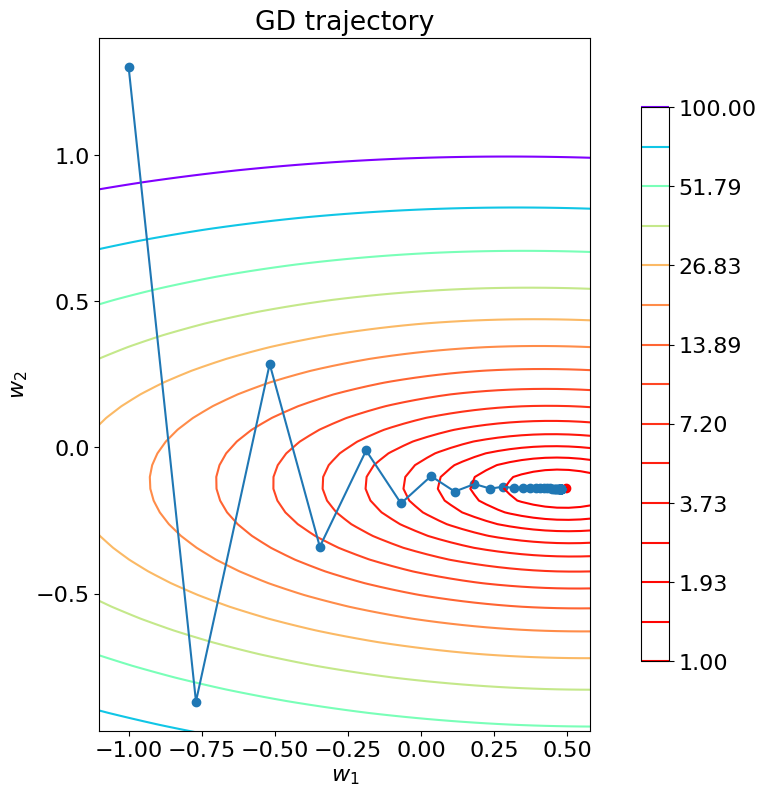

In [40]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))

plt.figure(figsize=(13, 9))
plt.title('GD trajectory')
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 2, num=15), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

Градиентный вектор ортогонален эквипотенциальной плоскости. Это причина, по которой оптимизационный путь не такой гладкий. Давайте визуализируем градиентные направления, чтобы сделать их более чистыми.

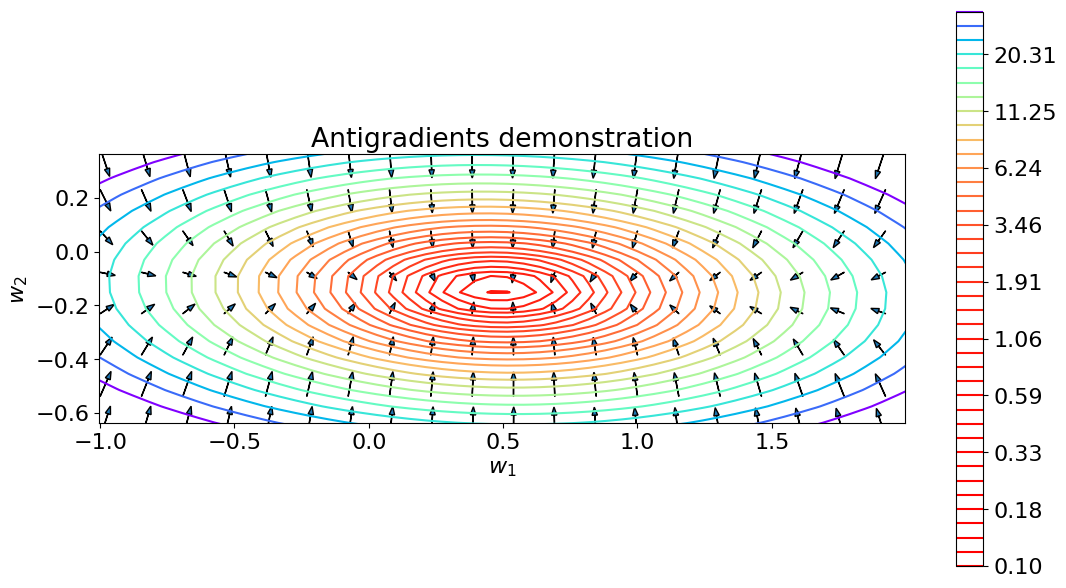

In [41]:
# compute level set
A, B = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
A_mini, B_mini = np.meshgrid(np.linspace(-3, 3, 40), np.linspace(-3, 3, 40))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
        
# visualize the level set
plt.figure(figsize=(13, 9))
CS = plt.contour(A, B, levels, levels=np.logspace(-1, 1.5, num=40), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
        
# visualize the gradients
gradients = np.empty_like(A_mini)
for i in range(A_mini.shape[0]):
    for j in range(A_mini.shape[1]):
        w_tmp = np.array([A_mini[i, j], B_mini[i, j]])
        antigrad = - 2 * 1e-3 * np.dot(X.T, np.dot(X, w_tmp) - Y) / Y.shape[0]
        plt.arrow(A_mini[i, j], B_mini[i, j], antigrad[0], antigrad[1], head_width=0.02)

plt.title('Antigradients demonstration')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_true[0] - 1.5, w_true[0] + 1.5))
plt.ylim((w_true[1] - .5, w_true[1] + .5))
plt.gca().set_aspect('equal')
plt.show()

Теперь давайте взглянем на _стохастический градиентный спуск_. Пусть число элементов функции потери, вычисленные на каждом ядре будут равны 10.

In [42]:
np.random.seed(random_seed)
batch_size = 10
w = w_0.copy()
w_history_list = [w.copy()]
lr = 1e-2

for i in range(2*num_steps):
    sample_indices = np.random.randint(0, n_objects, batch_size) # YOUR CODE HERE
    X_batch = X[sample_indices, :]
    Y_batch = Y[sample_indices]
    w -= 2 * lr * np.dot(X_batch.T, X_batch @ w - Y_batch) / batch_size # YOUR CODE HERE
    w_history_list.append(w.copy())
w_history_list = np.array(w_history_list)

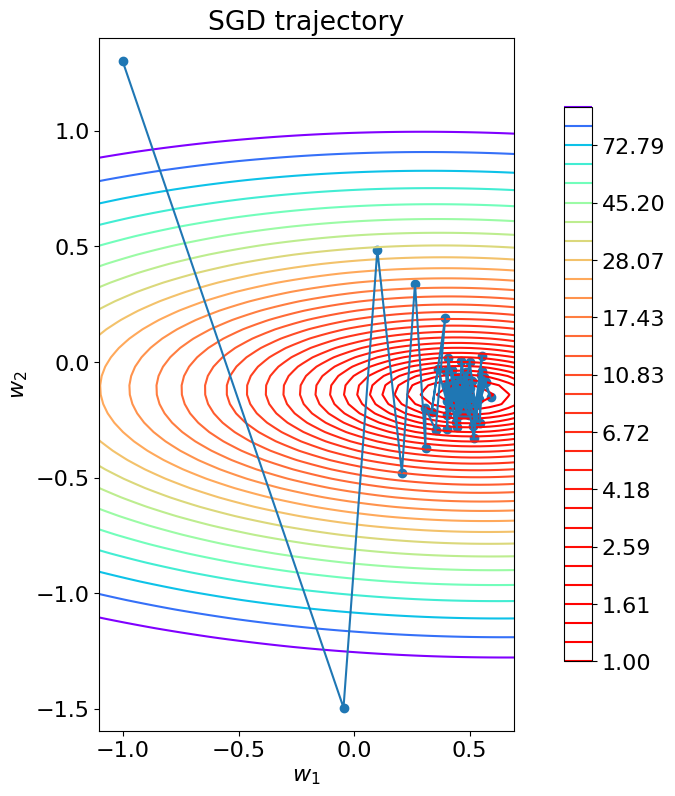

In [43]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_history_list[:, 0].min() - 0.1, w_history_list[:, 0].max() + 0.1))
plt.ylim((w_history_list[:, 1].min() - 0.1, w_history_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 2, num=30), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_history_list[:, 0], w_history_list[:, 1])
plt.plot(w_history_list[:, 0], w_history_list[:, 1])

plt.show()

Как мы можем увидеть на графике, SGD "кружит" вокруг центра. Это контролируется с помощью параметра `step size` SGD $\eta_k$ и сходимость не гарантирована в общем случае. Для метода SGD сходимость данной последовательности шагов $\{\eta_k\}$ определяется условиями [Роббинса-Монро](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586):
$$
\sum_{k = 1}^\infty \eta_k = \infty, \qquad \sum_{k = 1}^\infty \eta_k^2 < \infty.
$$
Простыми словами, эти условия могут быть переформулированы как:
1. Последовательность шагов $\{\eta_k\}$ должна расходиться, чтобы метод оптимизации мог достигать любую точку в данном пространстве параметров
2. В то же время оно должно расходиться "не так быстро"

Давайте проанализируем траектории SGD, которые созданы последовательностью шагов, удовлетворяющих условиям Роббинса-Монро:

In [44]:
np.random.seed(random_seed)
w = w_0.copy()
w_list = [w.copy()]
lr_0 = 0.02

for i in range(num_steps):
    lr = lr_0 / ((i+1) ** 0.5005) # What should the power be? )
    sample_indices = np.random.randint(0, n_objects, batch_size) # YOUR CODE HERE
    X_batch = X[sample_indices, :]
    Y_batch = Y[sample_indices]
    w -= 2 * lr * np.dot(X_batch.T, X_batch @ w - Y_batch) / batch_size # YOUR CODE HERE

    w_list.append(w.copy())
w_list = np.array(w_list)

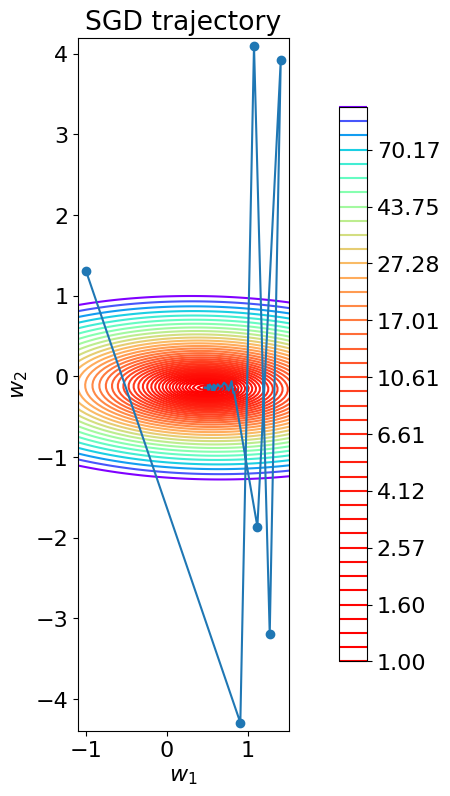

In [45]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))

plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 2, num=40), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

На практике же так не делают. На практике делают learning rate schedular

### Сранение скорости сходимости
Наконец, важно сравнить скорость сходимости для полного и стохастического градиентного спуска. Давайте создадим случайный датасет и нарисуем значение функции потери для каждой итерации

In [46]:
# data generation
n_features = 50
n_objects = 1000
num_steps = 500
batch_size = 10

w_true = np.random.uniform(-2, 2, n_features)

X = np.random.uniform(-10, 10, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 5, n_objects)

In [47]:
lr_sgd = 1e-3
lr_gd = 1e-3
w_sgd = np.random.uniform(-4, 4, n_features)
w_gd = w_sgd.copy()
residuals_sgd = [np.mean(np.power(np.dot(X, w_sgd) - Y, 2))]
residuals_gd = [np.mean(np.power(np.dot(X, w_gd) - Y, 2))]

for i in range(num_steps):
    lr = lr_sgd / ((i+1) ** 0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    w_sgd -= 2 * lr * np.dot(X[sample].T, np.dot(X[sample], w_sgd) - Y[sample]) / batch_size
    residuals_sgd.append(np.mean(np.power(np.dot(X, w_sgd) - Y, 2)))
    
    w_gd -= 2 * lr_gd * np.dot(X.T, np.dot(X, w_gd) - Y) / Y.shape[0]
    residuals_gd.append(np.mean(np.power(np.dot(X, w_gd) - Y, 2)))

In [48]:
for i in range(num_steps*4):
    lr = lr_sgd / ((i+1) ** 0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    w_sgd -= 2 * lr * np.dot(X[sample].T, np.dot(X[sample], w_sgd) - Y[sample]) / batch_size
    residuals_sgd.append(np.mean(np.power(np.dot(X, w_sgd) - Y, 2)))

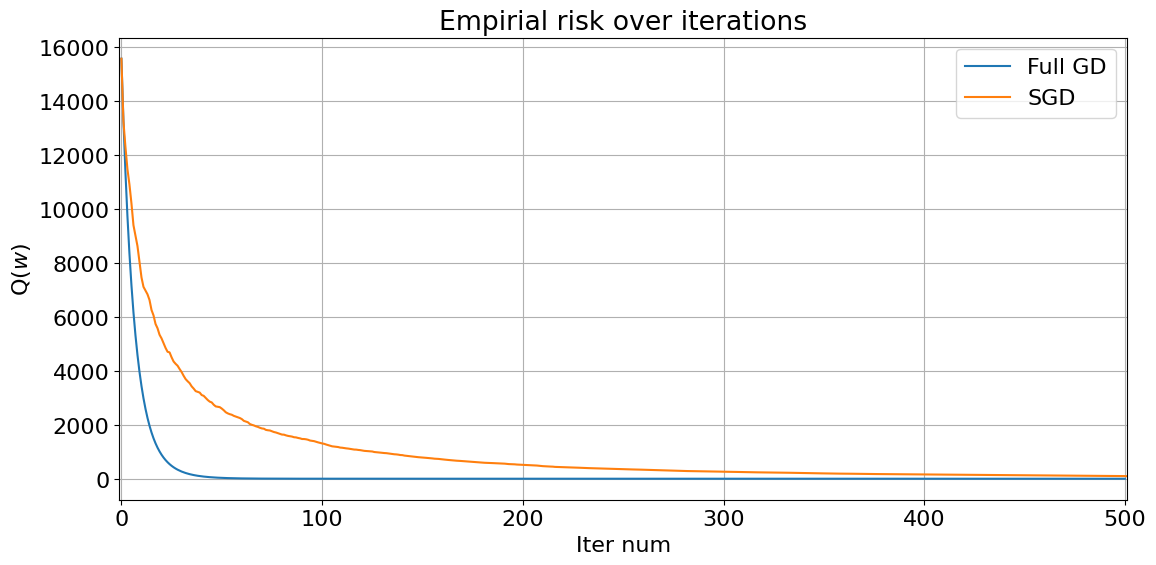

In [49]:
plt.figure(figsize=(13, 6))
plt.plot(np.arange(len(residuals_gd)), residuals_gd, label='Full GD')
plt.plot(np.arange(len(residuals_sgd)), residuals_sgd, label='SGD')
plt.title('Empirial risk over iterations')
plt.xlim((-1, len(residuals_gd)))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'Q($w$)')
plt.grid()
plt.show()

Как показано, градиентный спуск достигает оптимума всего за несколько итераций, в то время как стохастический градиентный спуск более нестабилен и требует больше времени для схождения. Обычно более большие модели демонстрируют бОльшие флуктуации для меньших значений функции в процессе схождения методом стохастики. На практике же, размер шага SGD может быть подобран так, что будет достигаться наилучшая скорость схождения, и есть несколько методов которые дают адаптивный размер шага градиентного спуска: AdaGrad, Adam, RMSProp и т.д.

### Дополнительно: анализ стабильности
Используя новую технику, давайте проанализируем поведение линейной регрессии в случае мультиколлинеарных фич.

В случае (мульти-)коллинеарных фич решение *нестабильно*. Давайте взглянем на *condition number* нашей матрицы:
$$\kappa(a) = \frac{\sigma _{\max }(A)}{\sigma _{\min }(A)}$$
, где $\sigma _{\max }(A)$ and $\sigma _{\min }(A)$ - это максимальные и минимальные сингулярные значения нашей матрицы $A$ соответственно.

In [50]:
def get_w_by_grad(X, Y, num_steps, w_0, lr):
    w = w_0.copy()

    for i in range(num_steps):
        w -= 2 * lr * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    return w

def get_w_by_stoch_grad(X, Y, num_steps, w_0, lr_0, n_objects):
    w = w_0.copy()
    lr_0 = 0.45

    for i in range(num_steps):
        lr = lr_0 / ((i+1)**0.51)
        sample = np.random.randint(n_objects, size=batch_size)
        w -= 2 * lr * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    return w

def rmse(y_true, y_pred):
    return np.linalg.norm(y_true-y_pred)

In [51]:
lr = 1e-3
sgd_lr = 0.1
num_steps = 250
noise_eps_seq = np.logspace(-2, -6, 20)

w_0 = np.random.uniform(-2, 2, (n_features))

In [52]:
condition_numbers = []
vector_norms_list = []
rmse_list = []
results_list = []
for eps in noise_eps_seq:
    local_condition_numbers = []
    local_vector_norms_list = []
    local_rmse_list = []
    for i in range(50):
        X[:, -1] = 2 * (X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape))

        a = np.linalg.eigvals(X.T.dot(X))
        local_condition_numbers.append(a.max() / a.min())

        w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
        w_star_grad = get_w_by_grad(X, Y, num_steps, w_0, lr)
        w_star_sgd = get_w_by_stoch_grad(X, Y, num_steps, w_0, sgd_lr, n_objects)
        local_vector_norms_list.append([
            np.linalg.norm(w_star),
            np.linalg.norm(w_star_grad), 
            np.linalg.norm(w_star_sgd),
        ])

        analytical_predict = X.dot(w_star)
        grad_predict = X.dot(w_star_grad)
        sgd_predict = X.dot(w_star_sgd)
        
        local_rmse_list.append([
            rmse(Y, analytical_predict),
            rmse(Y, grad_predict),
            rmse(Y, sgd_predict),
        ])
        
        results_list.append([w_star, w_star_grad, w_star_sgd])

    condition_numbers.append([np.mean(local_condition_numbers), np.std(local_condition_numbers)])
    vector_norms_list.append([
        np.mean(np.array(local_vector_norms_list), axis=0),
        np.std(np.array(local_vector_norms_list), axis=0),
    ])
    rmse_list.append(np.mean(np.array(local_rmse_list), axis=0))

condition_numbers = np.array(condition_numbers)
vector_norms_list = np.array(vector_norms_list)
rmse_list = np.array(rmse_list)

Take a close look on the collected vectors:

In [53]:
from utils_02 import visualise

ModuleNotFoundError: No module named 'utils_02'

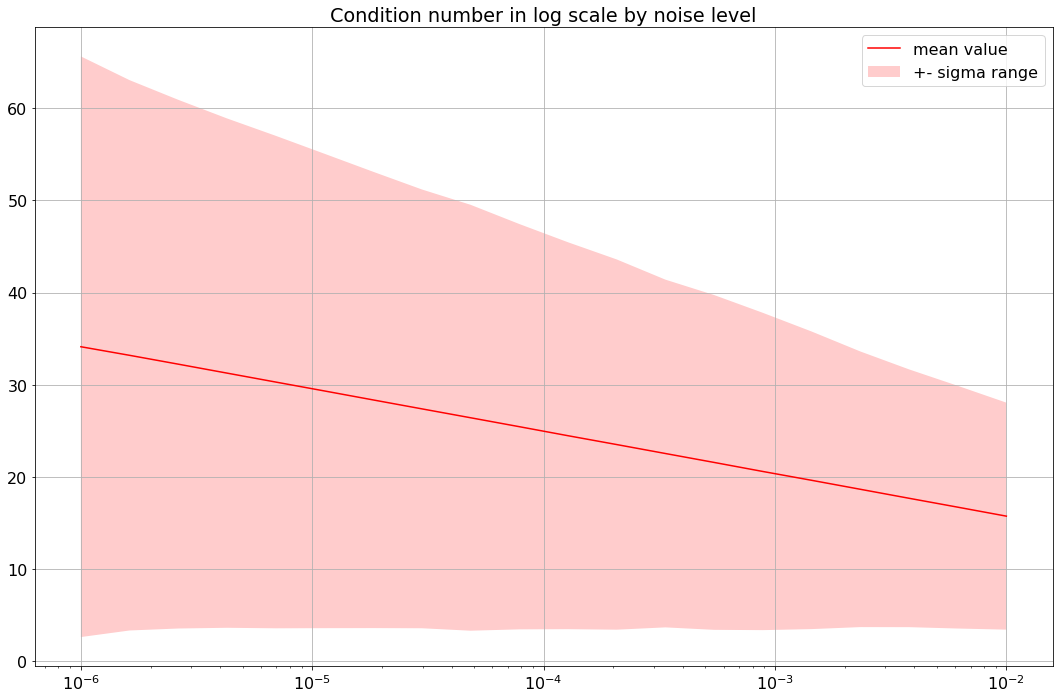

In [ ]:
visualise(
    np.log(condition_numbers[:, 0]), 
    np.log(condition_numbers[:, 1]),
    noise_eps_seq, 
    title='Condition number in log scale by noise level',
    greater_than_zero=True,
    log_scale=True
)

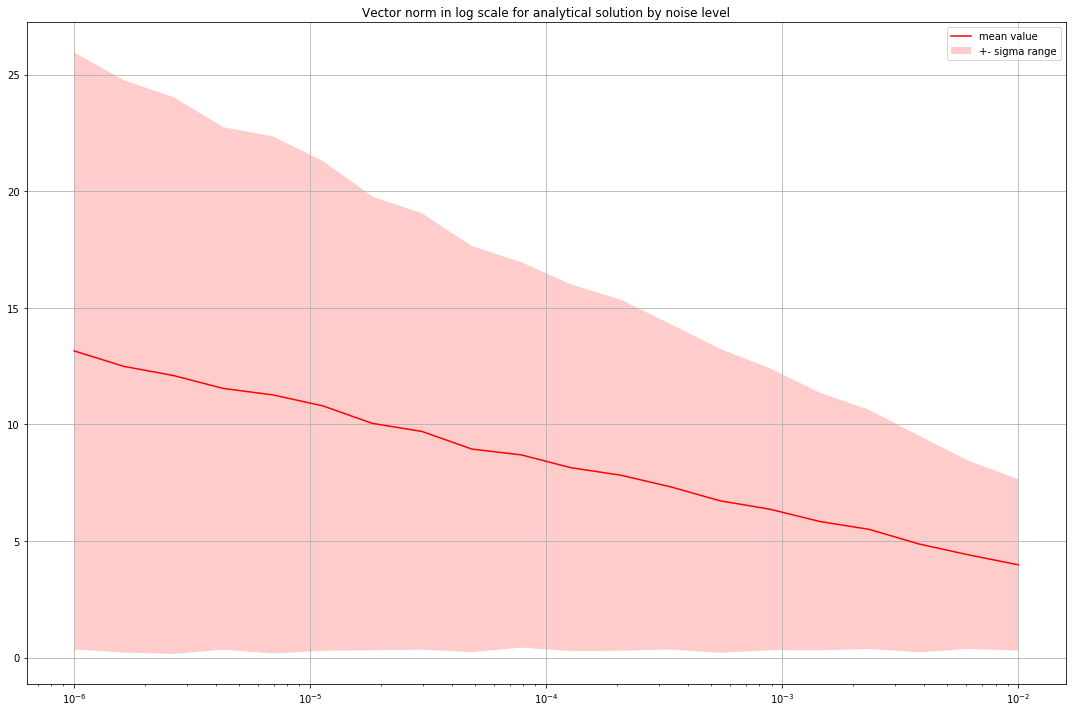

In [ ]:
visualise(
    np.log(vector_norms_list[:, 0, 0]), 
    np.log(vector_norms_list[:, 1, 0]),
    noise_eps_seq, 
    title='Vector norm in log scale for analytical solution by noise level',
    greater_than_zero=True,
    log_scale=True
)

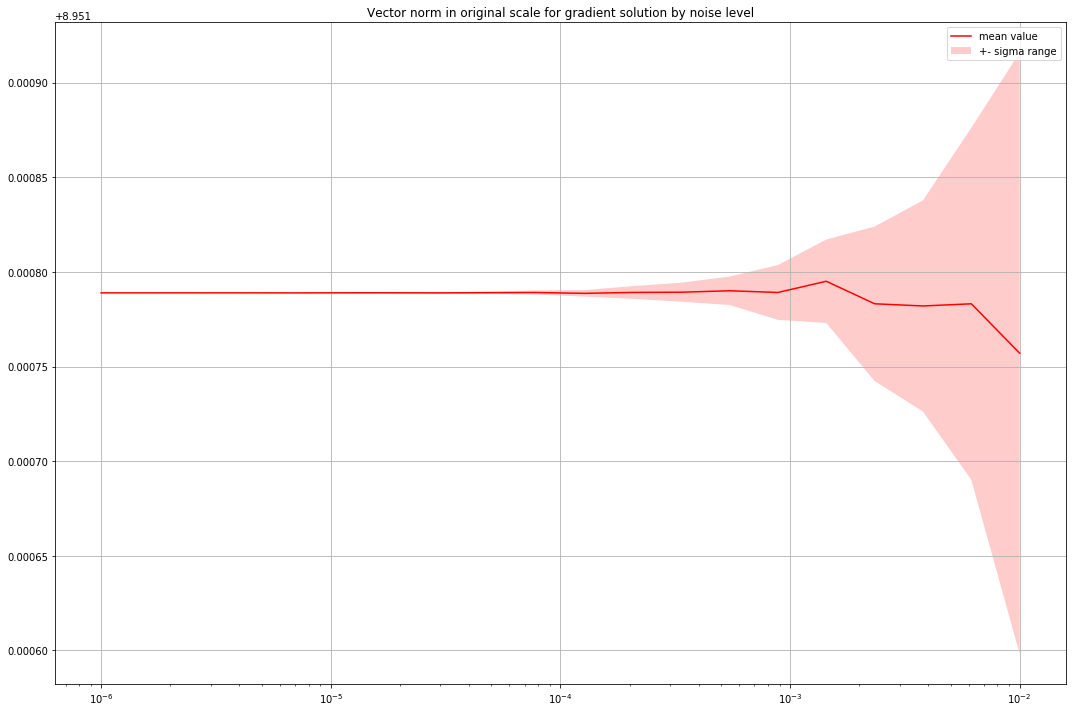

In [ ]:
visualise(
    vector_norms_list[:, 0, 1], 
    vector_norms_list[:, 1, 1],
    noise_eps_seq, 
    title='Vector norm in original scale for gradient solution by noise level',
    greater_than_zero=True,
    log_scale=True
)

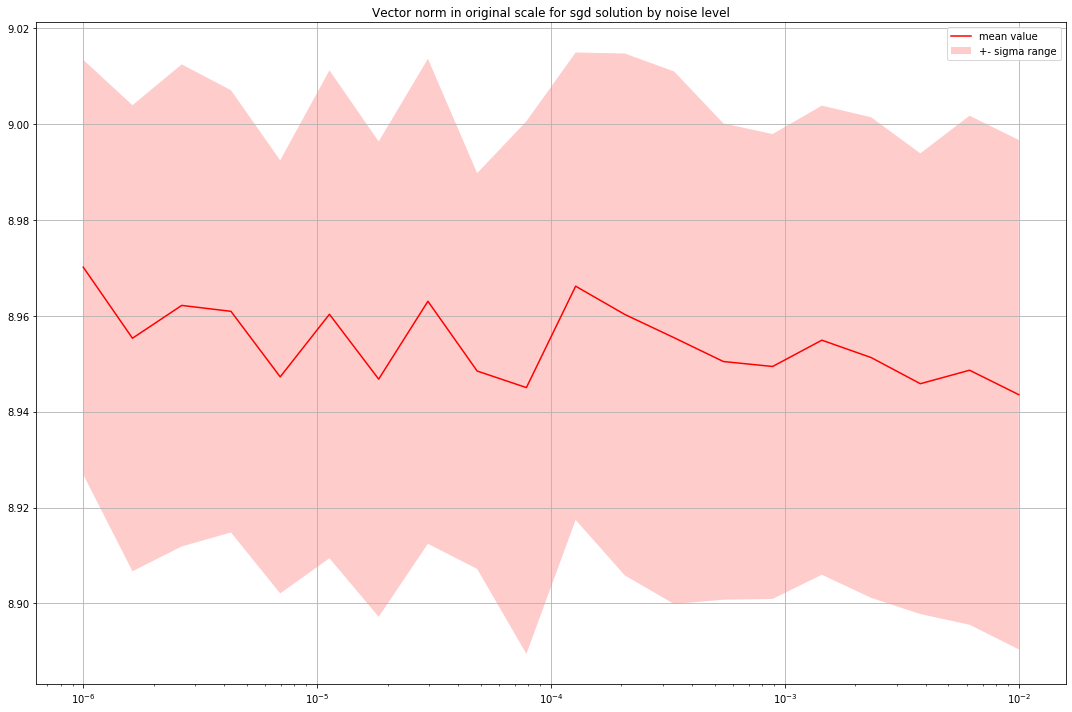

In [ ]:
visualise(
    vector_norms_list[:, 0, 2], 
    vector_norms_list[:, 1, 2],
    noise_eps_seq, 
    title='Vector norm in original scale for sgd solution by noise level',
    greater_than_zero=True,
    log_scale=True
)

## Линейная регрессия "из коробки"
Наконец, давайте взглянем на реализованные версии линейной регрессии из sklearn. Основные классы:

* [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) — классическая линейная регрессия (*на самом деле, это просто `scipy.linalg.lstsq`, обернутое классом `Predictor` из sklearn) - __аналитическое__ решение.
* [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) — линейная регрессия с $L_1$ регуляризацией.
* [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) — линейная регрессия с $L_2$ регуляризацией.

Чтобы минимизировать любую другую функцию ошибки, мы можем использовать [SGDRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)(или использовать отличный автоматический детерминирующий движок из *PyTorch*)

Давайте сравним скорость аналитического и градиентного решения из реализаций sklearn.

Будем использовать магическое засекание времени `%%time` из IPython

Чтобы измерить качество будем ипользовать счет $R^2$. Он сравнивает нашу модель (`a`) с другой, всегда предсказывая среднее `y`:

$$R^2 = 1 - \frac{\sum_i (y_i - a(x_i))^2}{\sum_i (y_i - \overline{y}_i)^2}$$
, где $R^2$ - коэффицент детерминации

`LinearRegression` vs. `Ridge`: __В бой!__

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [ ]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [ ]:
%%time

lr = LinearRegression()
lr.fit(X, Y)
print(f'R2: {lr.score(X, Y)}')

R2: 0.9999702505699795
CPU times: user 22.7 s, sys: 2.06 s, total: 24.8 s
Wall time: 10.6 s


In [ ]:
%%time

lr = Ridge(alpha=0.0, solver='sparse_cg')
lr.fit(X, Y)
print(f'R2: {lr.score(X, Y)}')

R2: 0.9999698901926024
CPU times: user 2.5 s, sys: 365 ms, total: 2.87 s
Wall time: 1.49 s


## Наша изящная версия Линейной Регрессии

Давайте используем стандартный интерфейс `sklearn`, чтобы реализовать нашу версию Линейной Регрессии, используя SGD

Сперва, нам нужно унаследовать базовые классы, затем реализовать 3 главные стадии жизни регрессора как методы:
* Конструктор - инициализация гиперпараметра
* Фиттинг - параметры тренируются на известных обьектах
* Предикт - оценка таргета для неизвестных обьектов

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
# also ClassifierMixin and TransformerMixin exist

In [ ]:
class LinearRergessionSGD(BaseEstimator, RegressorMixin):
    '''LinearRergession with L2 regularization and SGD optimizer
    '''
    def __init__(
        self, C: float=1.0,
        batch_size: int=25,
        lr: float=1e-2,
        num_steps: int=200,
    ) -> None:
        self.C = C
        self.batch_size = batch_size
        self.lr = lr
        self.num_steps = num_steps

    def fit(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)

        # this is just copied from above
        for i in range(self.num_steps):
            sample_indices = np.random.randint(n_objects, size=self.batch_size)
            w -= 2 * self.lr * np.dot(X[sample_indices].T, np.dot(X[sample_indices], w) - Y[sample_indices]) / self.batch_size

        self.w = w
        return self

    def predict(self, X):
        return X@self.w

Давайте сгенерируем датасет с разнонормированными фичами

In [ ]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features)) * np.arange(n_features)
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

и засплитим его на тренировочную и тестовую часть

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

Теперь давайте опробуем наше решение

In [ ]:
own_lr = LinearRergessionSGD().fit(x_train, y_train)
print(f'R2: {own_lr.score(x_test, y_test)}')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Упс!

Что-то пошло не так, что же это может быть?

В ходе SGD мы встретили слишком большие значение, для того чтобы поместить их в float

Это ведет нас к нормализации фич.
Давайте упорядочим наши фичи: просто вычтем среднее из каждой фичи и разделим на вариацию образца.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)

In [ ]:
own_lr = LinearRergessionSGD().fit(x_scaled, y_train)

Но для теста нам нужно упорядочить тестовые фичи

In [ ]:
x_test_scaled = scaler.transform(x_test)

In [ ]:
print(f'R2: {own_lr.score(x_test_scaled, y_test)}')

R2: 0.9965985718972877


Вау! Мы не реализовали метода `score`. Но базовый класс `sklearn`должен давать нам его уже реализованным

Вы уже заметили, что упорядочивание даты перед предсказанием - занятие не из приятных. Но мы можем избавиться от этой рутины с помощью пайплайнов!

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    LinearRergessionSGD(),
)

In [ ]:
pipe.fit(x_train, y_train)
print(f'R2: {pipe.score(x_test, y_test)}')

R2: 0.9965963277306727
